# ディレクトリ構成図
`
.  
├── data  
│   ├── cora  
│   ├── factset  
│         └── processed_data  
│               ├── edge.csv  
│               ├── feature.csv  
│               └── label.csv  
└── link_prediction  
      ├── model.py  
      ├── my_util.py  
      ├── example.ipynb <-We are here!  
      └── output  
`


# 1. ライブラリーのインポート

In [1]:
import os.path as osp

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score

import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.nn import Linear
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GCN2Conv
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import train_test_split_edges

import networkx as nx

# 同じディレクトリにある.py
import models
import my_utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Dataset の指定 -> train_test_split

`models.Link_Prediction_Model`をinitする際に、dataset名とvalidation比率、test比率を指定する。

- `dataset_name='cora'`の場合  
ディレクトリ`../data/cora/`が存在しない場合、新規に作成し、データをダウンロードする。


- `dataset_name='factset'`の場合  
ディレクトリ`../data/factset/processed_data/`に事前に`edge.csv`、`feature.csv`、`label.csv`を準備する。

In [2]:
model = models.Link_Prediction_Model(dataset_name='cora', val_ratio=0.05, test_ratio=0.1)

Processing...
Done!
dataset cora has been downloaded.
is undirected: True
contains self loops: False
num_nodes: 2708
num_edges: 10556

transformd the graph to undirected.

train test split has been done.
Data(test_neg_edge_index=[2, 527], test_pos_edge_index=[2, 527], train_neg_adj_mask=[2708, 2708], train_pos_edge_index=[2, 8976], val_neg_edge_index=[2, 263], val_pos_edge_index=[2, 263], x=[2708, 1433])

train_pos_edge_adj_t is completed.

y_true is completed.

y_train is completed.

data has been sent to cuda.


# 3. 学習

`models.Link_Prediction_Model`のインスタンスをcallすることで、新規に学習を開始する。（それまでの学習結果は破棄され、random_seedもリセットされる。train_test_splitされたデータは保持される。）

`my_optimizer`メソッドにより、独自のoptimizerを設定できる。

`run_training`メソッドにより`num_epoch`回の学習を行う。このメソッドは追加で複数回実行することができる。

In [3]:
model(modelname='GCN', 
          activation = 'relu', 
          self_loop_mask = True,
          num_hidden_channels = 256, 
          num_layers = 2, 
          hidden_channels = None, 
          dropout = 0.5,
          sigmoid_bias = True,
          negative_sampling_ratio = 1,
          threshold = 0.5
)

######################################
reset the model and the random seed.
model: GCN
num_layers: 2
activation: relu
sigmoid_bias: True
negative_sampling_ratio: 1
ready to train!



In [5]:
# 下記はDefaultで設定されているoptimizer
optimizer = torch.optim.Adam([
    {'params':model.model.bias.parameters(),'weight_decay':0.02},
    {'params':model.model.convs.parameters(),'weight_decay':0.01},
    {'params':model.model.lins.parameters(),'weight_decay':0.01}
    ],lr=0.01)
model.my_optimizer(optimizer)

In [6]:
model.run_training(num_epochs=1000)

Epoch: 001/1000, Train_loss: 35.0325, Val_loss: 0.6892, Val_Score: 0.7006, (Test_loss: 0.6900, Test_score: 0.6650)
Epoch: 002/1000, Train_loss: 49.8271, Val_loss: 0.6907, Val_Score: 0.6194, (Test_loss: 0.6923, Test_score: 0.5633)
Epoch: 003/1000, Train_loss: 49.9779, Val_loss: 0.6909, Val_Score: 0.6501, (Test_loss: 0.6944, Test_score: 0.6097)
Epoch: 004/1000, Train_loss: 49.9723, Val_loss: 0.7105, Val_Score: 0.6550, (Test_loss: 0.7152, Test_score: 0.6173)
Epoch: 005/1000, Train_loss: 49.9779, Val_loss: 0.7161, Val_Score: 0.6384, (Test_loss: 0.7217, Test_score: 0.5937)
Epoch: 006/1000, Train_loss: 49.9750, Val_loss: 0.7139, Val_Score: 0.6098, (Test_loss: 0.7200, Test_score: 0.5586)
Epoch: 007/1000, Train_loss: 49.9364, Val_loss: 0.7243, Val_Score: 0.6257, (Test_loss: 0.7308, Test_score: 0.5728)
Epoch: 008/1000, Train_loss: 49.9889, Val_loss: 0.7563, Val_Score: 0.6503, (Test_loss: 0.7636, Test_score: 0.5999)
Epoch: 009/1000, Train_loss: 49.9695, Val_loss: 0.7906, Val_Score: 0.6572, (Test

Epoch: 075/1000, Train_loss: 4.1489, Val_loss: 1.1975, Val_Score: 0.6669, (Test_loss: 1.6380, Test_score: 0.7019)
Epoch: 076/1000, Train_loss: 4.4785, Val_loss: 1.1495, Val_Score: 0.6774, (Test_loss: 1.0285, Test_score: 0.7063)
Epoch: 077/1000, Train_loss: 4.1204, Val_loss: 1.1052, Val_Score: 0.6727, (Test_loss: 0.9049, Test_score: 0.7059)
Epoch: 078/1000, Train_loss: 3.6931, Val_loss: 1.0861, Val_Score: 0.6653, (Test_loss: 0.8957, Test_score: 0.6999)
Epoch: 079/1000, Train_loss: 3.5641, Val_loss: 0.7146, Val_Score: 0.6734, (Test_loss: 0.8219, Test_score: 0.6973)
Epoch: 080/1000, Train_loss: 2.9770, Val_loss: 1.0722, Val_Score: 0.6592, (Test_loss: 0.8913, Test_score: 0.6956)
Epoch: 081/1000, Train_loss: 3.4375, Val_loss: 0.8990, Val_Score: 0.6718, (Test_loss: 0.8710, Test_score: 0.7067)
Epoch: 082/1000, Train_loss: 3.1222, Val_loss: 0.8960, Val_Score: 0.6527, (Test_loss: 0.8670, Test_score: 0.6857)
Epoch: 083/1000, Train_loss: 2.7378, Val_loss: 0.6905, Val_Score: 0.6863, (Test_loss: 0.

Epoch: 150/1000, Train_loss: 0.2582, Val_loss: 0.3595, Val_Score: 0.9356, (Test_loss: 0.3550, Test_score: 0.9384)
Epoch: 151/1000, Train_loss: 0.2594, Val_loss: 0.3570, Val_Score: 0.9352, (Test_loss: 0.3477, Test_score: 0.9418)
Epoch: 152/1000, Train_loss: 0.2615, Val_loss: 0.3572, Val_Score: 0.9357, (Test_loss: 0.3431, Test_score: 0.9440)
Epoch: 153/1000, Train_loss: 0.2637, Val_loss: 0.3626, Val_Score: 0.9355, (Test_loss: 0.3468, Test_score: 0.9430)
Epoch: 154/1000, Train_loss: 0.2669, Val_loss: 0.3670, Val_Score: 0.9341, (Test_loss: 0.3523, Test_score: 0.9411)
Epoch: 155/1000, Train_loss: 0.2573, Val_loss: 0.3620, Val_Score: 0.9345, (Test_loss: 0.3520, Test_score: 0.9399)
Epoch: 156/1000, Train_loss: 0.2628, Val_loss: 0.3595, Val_Score: 0.9335, (Test_loss: 0.3513, Test_score: 0.9382)
Epoch: 157/1000, Train_loss: 0.2548, Val_loss: 0.3599, Val_Score: 0.9344, (Test_loss: 0.3531, Test_score: 0.9375)
Epoch: 158/1000, Train_loss: 0.2510, Val_loss: 0.3635, Val_Score: 0.9371, (Test_loss: 0.

Epoch: 222/1000, Train_loss: 0.2145, Val_loss: 0.3343, Val_Score: 0.9376, (Test_loss: 0.3548, Test_score: 0.9244)
Epoch: 223/1000, Train_loss: 0.2221, Val_loss: 0.3361, Val_Score: 0.9407, (Test_loss: 0.3622, Test_score: 0.9222)
Epoch: 224/1000, Train_loss: 0.2181, Val_loss: 0.3397, Val_Score: 0.9421, (Test_loss: 0.3718, Test_score: 0.9203)
Epoch: 225/1000, Train_loss: 0.2146, Val_loss: 0.3434, Val_Score: 0.9429, (Test_loss: 0.3741, Test_score: 0.9216)
Epoch: 226/1000, Train_loss: 0.2176, Val_loss: 0.3460, Val_Score: 0.9402, (Test_loss: 0.3720, Test_score: 0.9240)
Epoch: 227/1000, Train_loss: 0.2199, Val_loss: 0.3460, Val_Score: 0.9353, (Test_loss: 0.3684, Test_score: 0.9236)
Epoch: 228/1000, Train_loss: 0.2160, Val_loss: 0.3409, Val_Score: 0.9384, (Test_loss: 0.3623, Test_score: 0.9252)
Epoch: 229/1000, Train_loss: 0.2264, Val_loss: 0.3355, Val_Score: 0.9427, (Test_loss: 0.3668, Test_score: 0.9219)
Epoch: 230/1000, Train_loss: 0.2222, Val_loss: 0.3284, Val_Score: 0.9442, (Test_loss: 0.

Epoch: 297/1000, Train_loss: 0.2072, Val_loss: 0.3402, Val_Score: 0.9345, (Test_loss: 0.3503, Test_score: 0.9309)
Epoch: 298/1000, Train_loss: 0.2052, Val_loss: 0.3396, Val_Score: 0.9351, (Test_loss: 0.3510, Test_score: 0.9291)
Epoch: 299/1000, Train_loss: 0.2130, Val_loss: 0.3518, Val_Score: 0.9309, (Test_loss: 0.3639, Test_score: 0.9245)
Epoch: 300/1000, Train_loss: 0.2045, Val_loss: 0.3569, Val_Score: 0.9306, (Test_loss: 0.3655, Test_score: 0.9248)
Epoch: 301/1000, Train_loss: 0.2022, Val_loss: 0.3542, Val_Score: 0.9315, (Test_loss: 0.3539, Test_score: 0.9284)
Epoch: 302/1000, Train_loss: 0.2025, Val_loss: 0.3466, Val_Score: 0.9312, (Test_loss: 0.3405, Test_score: 0.9296)
Epoch: 303/1000, Train_loss: 0.2083, Val_loss: 0.3452, Val_Score: 0.9321, (Test_loss: 0.3405, Test_score: 0.9304)
Epoch: 304/1000, Train_loss: 0.2063, Val_loss: 0.3502, Val_Score: 0.9329, (Test_loss: 0.3551, Test_score: 0.9285)
Epoch: 305/1000, Train_loss: 0.2070, Val_loss: 0.3417, Val_Score: 0.9343, (Test_loss: 0.

Epoch: 371/1000, Train_loss: 0.1974, Val_loss: 0.3427, Val_Score: 0.9356, (Test_loss: 0.3512, Test_score: 0.9337)
Epoch: 372/1000, Train_loss: 0.2004, Val_loss: 0.3499, Val_Score: 0.9348, (Test_loss: 0.3523, Test_score: 0.9336)
Epoch: 373/1000, Train_loss: 0.2017, Val_loss: 0.3521, Val_Score: 0.9345, (Test_loss: 0.3499, Test_score: 0.9337)
Epoch: 374/1000, Train_loss: 0.1962, Val_loss: 0.3480, Val_Score: 0.9364, (Test_loss: 0.3488, Test_score: 0.9329)
Epoch: 375/1000, Train_loss: 0.2015, Val_loss: 0.3409, Val_Score: 0.9394, (Test_loss: 0.3487, Test_score: 0.9335)
Epoch: 376/1000, Train_loss: 0.1892, Val_loss: 0.3321, Val_Score: 0.9381, (Test_loss: 0.3485, Test_score: 0.9314)
Epoch: 377/1000, Train_loss: 0.2026, Val_loss: 0.3380, Val_Score: 0.9336, (Test_loss: 0.3560, Test_score: 0.9282)
Epoch: 378/1000, Train_loss: 0.1968, Val_loss: 0.3432, Val_Score: 0.9314, (Test_loss: 0.3606, Test_score: 0.9279)
Epoch: 379/1000, Train_loss: 0.1974, Val_loss: 0.3436, Val_Score: 0.9335, (Test_loss: 0.

Epoch: 447/1000, Train_loss: 0.2037, Val_loss: 0.3462, Val_Score: 0.9352, (Test_loss: 0.3607, Test_score: 0.9283)
Epoch: 448/1000, Train_loss: 0.2086, Val_loss: 0.3680, Val_Score: 0.9259, (Test_loss: 0.3700, Test_score: 0.9255)
Epoch: 449/1000, Train_loss: 0.2068, Val_loss: 0.3862, Val_Score: 0.9193, (Test_loss: 0.3683, Test_score: 0.9279)
Epoch: 450/1000, Train_loss: 0.2146, Val_loss: 0.3697, Val_Score: 0.9238, (Test_loss: 0.3504, Test_score: 0.9320)
Epoch: 451/1000, Train_loss: 0.1999, Val_loss: 0.3497, Val_Score: 0.9279, (Test_loss: 0.3409, Test_score: 0.9346)
Epoch: 452/1000, Train_loss: 0.1918, Val_loss: 0.3383, Val_Score: 0.9288, (Test_loss: 0.3389, Test_score: 0.9330)
Epoch: 453/1000, Train_loss: 0.1948, Val_loss: 0.3419, Val_Score: 0.9283, (Test_loss: 0.3504, Test_score: 0.9288)
Epoch: 454/1000, Train_loss: 0.1954, Val_loss: 0.3490, Val_Score: 0.9292, (Test_loss: 0.3604, Test_score: 0.9286)
Epoch: 455/1000, Train_loss: 0.1905, Val_loss: 0.3597, Val_Score: 0.9272, (Test_loss: 0.

Epoch: 519/1000, Train_loss: 0.2077, Val_loss: 0.3418, Val_Score: 0.9378, (Test_loss: 0.3468, Test_score: 0.9366)
Epoch: 520/1000, Train_loss: 0.2005, Val_loss: 0.3501, Val_Score: 0.9367, (Test_loss: 0.3588, Test_score: 0.9337)
Epoch: 521/1000, Train_loss: 0.1952, Val_loss: 0.3542, Val_Score: 0.9365, (Test_loss: 0.3658, Test_score: 0.9308)
Epoch: 522/1000, Train_loss: 0.2002, Val_loss: 0.3516, Val_Score: 0.9340, (Test_loss: 0.3571, Test_score: 0.9312)
Epoch: 523/1000, Train_loss: 0.2059, Val_loss: 0.3593, Val_Score: 0.9279, (Test_loss: 0.3577, Test_score: 0.9301)
Epoch: 524/1000, Train_loss: 0.1982, Val_loss: 0.3709, Val_Score: 0.9232, (Test_loss: 0.3630, Test_score: 0.9306)
Epoch: 525/1000, Train_loss: 0.1911, Val_loss: 0.3741, Val_Score: 0.9231, (Test_loss: 0.3676, Test_score: 0.9303)
Epoch: 526/1000, Train_loss: 0.2132, Val_loss: 0.3670, Val_Score: 0.9260, (Test_loss: 0.3685, Test_score: 0.9300)
Epoch: 527/1000, Train_loss: 0.1959, Val_loss: 0.3655, Val_Score: 0.9264, (Test_loss: 0.

Epoch: 592/1000, Train_loss: 0.2021, Val_loss: 0.3846, Val_Score: 0.9302, (Test_loss: 0.3955, Test_score: 0.9258)
Epoch: 593/1000, Train_loss: 0.1875, Val_loss: 0.3753, Val_Score: 0.9313, (Test_loss: 0.3892, Test_score: 0.9259)
Epoch: 594/1000, Train_loss: 0.2078, Val_loss: 0.3532, Val_Score: 0.9330, (Test_loss: 0.3620, Test_score: 0.9306)
Epoch: 595/1000, Train_loss: 0.2058, Val_loss: 0.3507, Val_Score: 0.9318, (Test_loss: 0.3527, Test_score: 0.9316)
Epoch: 596/1000, Train_loss: 0.2004, Val_loss: 0.3467, Val_Score: 0.9351, (Test_loss: 0.3520, Test_score: 0.9306)
Epoch: 597/1000, Train_loss: 0.2029, Val_loss: 0.3578, Val_Score: 0.9339, (Test_loss: 0.3607, Test_score: 0.9283)
Epoch: 598/1000, Train_loss: 0.2052, Val_loss: 0.3648, Val_Score: 0.9318, (Test_loss: 0.3645, Test_score: 0.9274)
Epoch: 599/1000, Train_loss: 0.2016, Val_loss: 0.3682, Val_Score: 0.9305, (Test_loss: 0.3693, Test_score: 0.9266)
Epoch: 600/1000, Train_loss: 0.2011, Val_loss: 0.3565, Val_Score: 0.9302, (Test_loss: 0.

Epoch: 664/1000, Train_loss: 0.1977, Val_loss: 0.3265, Val_Score: 0.9468, (Test_loss: 0.3579, Test_score: 0.9321)
Epoch: 665/1000, Train_loss: 0.2043, Val_loss: 0.3127, Val_Score: 0.9511, (Test_loss: 0.3449, Test_score: 0.9367)
Epoch: 666/1000, Train_loss: 0.1992, Val_loss: 0.3157, Val_Score: 0.9509, (Test_loss: 0.3449, Test_score: 0.9367)
Epoch: 667/1000, Train_loss: 0.1958, Val_loss: 0.3337, Val_Score: 0.9427, (Test_loss: 0.3486, Test_score: 0.9335)
Epoch: 668/1000, Train_loss: 0.2156, Val_loss: 0.3343, Val_Score: 0.9433, (Test_loss: 0.3483, Test_score: 0.9354)
Epoch: 669/1000, Train_loss: 0.2073, Val_loss: 0.3217, Val_Score: 0.9472, (Test_loss: 0.3497, Test_score: 0.9352)
Epoch: 670/1000, Train_loss: 0.2014, Val_loss: 0.3286, Val_Score: 0.9461, (Test_loss: 0.3630, Test_score: 0.9311)
Epoch: 671/1000, Train_loss: 0.2055, Val_loss: 0.3394, Val_Score: 0.9398, (Test_loss: 0.3638, Test_score: 0.9303)
Epoch: 672/1000, Train_loss: 0.1960, Val_loss: 0.3424, Val_Score: 0.9398, (Test_loss: 0.

Epoch: 739/1000, Train_loss: 0.2025, Val_loss: 0.3695, Val_Score: 0.9348, (Test_loss: 0.3603, Test_score: 0.9353)
Epoch: 740/1000, Train_loss: 0.1998, Val_loss: 0.3738, Val_Score: 0.9311, (Test_loss: 0.3625, Test_score: 0.9335)
Epoch: 741/1000, Train_loss: 0.2040, Val_loss: 0.3585, Val_Score: 0.9277, (Test_loss: 0.3348, Test_score: 0.9378)
Epoch: 742/1000, Train_loss: 0.2071, Val_loss: 0.3419, Val_Score: 0.9327, (Test_loss: 0.3206, Test_score: 0.9426)
Epoch: 743/1000, Train_loss: 0.2009, Val_loss: 0.3322, Val_Score: 0.9409, (Test_loss: 0.3191, Test_score: 0.9433)
Epoch: 744/1000, Train_loss: 0.2059, Val_loss: 0.3432, Val_Score: 0.9385, (Test_loss: 0.3307, Test_score: 0.9409)
Epoch: 745/1000, Train_loss: 0.2159, Val_loss: 0.3517, Val_Score: 0.9400, (Test_loss: 0.3346, Test_score: 0.9439)
Epoch: 746/1000, Train_loss: 0.1991, Val_loss: 0.3501, Val_Score: 0.9374, (Test_loss: 0.3363, Test_score: 0.9438)
Epoch: 747/1000, Train_loss: 0.2082, Val_loss: 0.3563, Val_Score: 0.9341, (Test_loss: 0.

Epoch: 812/1000, Train_loss: 0.2248, Val_loss: 0.3493, Val_Score: 0.9312, (Test_loss: 0.3603, Test_score: 0.9324)
Epoch: 813/1000, Train_loss: 0.2028, Val_loss: 0.3438, Val_Score: 0.9339, (Test_loss: 0.3514, Test_score: 0.9348)
Epoch: 814/1000, Train_loss: 0.2095, Val_loss: 0.3581, Val_Score: 0.9297, (Test_loss: 0.3603, Test_score: 0.9332)
Epoch: 815/1000, Train_loss: 0.2055, Val_loss: 0.3617, Val_Score: 0.9256, (Test_loss: 0.3581, Test_score: 0.9328)
Epoch: 816/1000, Train_loss: 0.1987, Val_loss: 0.3541, Val_Score: 0.9262, (Test_loss: 0.3426, Test_score: 0.9325)
Epoch: 817/1000, Train_loss: 0.2106, Val_loss: 0.3553, Val_Score: 0.9283, (Test_loss: 0.3410, Test_score: 0.9355)
Epoch: 818/1000, Train_loss: 0.1931, Val_loss: 0.3595, Val_Score: 0.9264, (Test_loss: 0.3446, Test_score: 0.9347)
Epoch: 819/1000, Train_loss: 0.2082, Val_loss: 0.3401, Val_Score: 0.9343, (Test_loss: 0.3412, Test_score: 0.9362)
Epoch: 820/1000, Train_loss: 0.2031, Val_loss: 0.3326, Val_Score: 0.9358, (Test_loss: 0.

Epoch: 885/1000, Train_loss: 0.1964, Val_loss: 0.3703, Val_Score: 0.9199, (Test_loss: 0.3383, Test_score: 0.9415)
Epoch: 886/1000, Train_loss: 0.1971, Val_loss: 0.3545, Val_Score: 0.9256, (Test_loss: 0.3278, Test_score: 0.9437)
Epoch: 887/1000, Train_loss: 0.2056, Val_loss: 0.3558, Val_Score: 0.9250, (Test_loss: 0.3291, Test_score: 0.9424)
Epoch: 888/1000, Train_loss: 0.2074, Val_loss: 0.3697, Val_Score: 0.9174, (Test_loss: 0.3414, Test_score: 0.9383)
Epoch: 889/1000, Train_loss: 0.2059, Val_loss: 0.3718, Val_Score: 0.9208, (Test_loss: 0.3558, Test_score: 0.9339)
Epoch: 890/1000, Train_loss: 0.1997, Val_loss: 0.3530, Val_Score: 0.9302, (Test_loss: 0.3536, Test_score: 0.9330)
Epoch: 891/1000, Train_loss: 0.2103, Val_loss: 0.3370, Val_Score: 0.9358, (Test_loss: 0.3507, Test_score: 0.9342)
Epoch: 892/1000, Train_loss: 0.1992, Val_loss: 0.3385, Val_Score: 0.9318, (Test_loss: 0.3454, Test_score: 0.9330)
Epoch: 893/1000, Train_loss: 0.2149, Val_loss: 0.3477, Val_Score: 0.9323, (Test_loss: 0.

Epoch: 958/1000, Train_loss: 0.2000, Val_loss: 0.3515, Val_Score: 0.9334, (Test_loss: 0.3615, Test_score: 0.9340)
Epoch: 959/1000, Train_loss: 0.2106, Val_loss: 0.3387, Val_Score: 0.9369, (Test_loss: 0.3454, Test_score: 0.9377)
Epoch: 960/1000, Train_loss: 0.2010, Val_loss: 0.3539, Val_Score: 0.9316, (Test_loss: 0.3519, Test_score: 0.9386)
Epoch: 961/1000, Train_loss: 0.1996, Val_loss: 0.3352, Val_Score: 0.9375, (Test_loss: 0.3401, Test_score: 0.9392)
Epoch: 962/1000, Train_loss: 0.2130, Val_loss: 0.3666, Val_Score: 0.9264, (Test_loss: 0.3653, Test_score: 0.9345)
Epoch: 963/1000, Train_loss: 0.2042, Val_loss: 0.3689, Val_Score: 0.9222, (Test_loss: 0.3587, Test_score: 0.9336)
Epoch: 964/1000, Train_loss: 0.2169, Val_loss: 0.3787, Val_Score: 0.9222, (Test_loss: 0.3630, Test_score: 0.9334)
Epoch: 965/1000, Train_loss: 0.2005, Val_loss: 0.3743, Val_Score: 0.9188, (Test_loss: 0.3582, Test_score: 0.9326)
Epoch: 966/1000, Train_loss: 0.2076, Val_loss: 0.3792, Val_Score: 0.9166, (Test_loss: 0.

# 3. 学習結果の確認・結果の保存

- `validation = True`の場合  
validationのAUCが最も良いepoch数でtestデータを検証する。


- `validation = False`の場合  
最終epochでtestデータを検証する。


- `validation = True`の場合  
グラフやログを`./output/`ディレクトリに保存する。

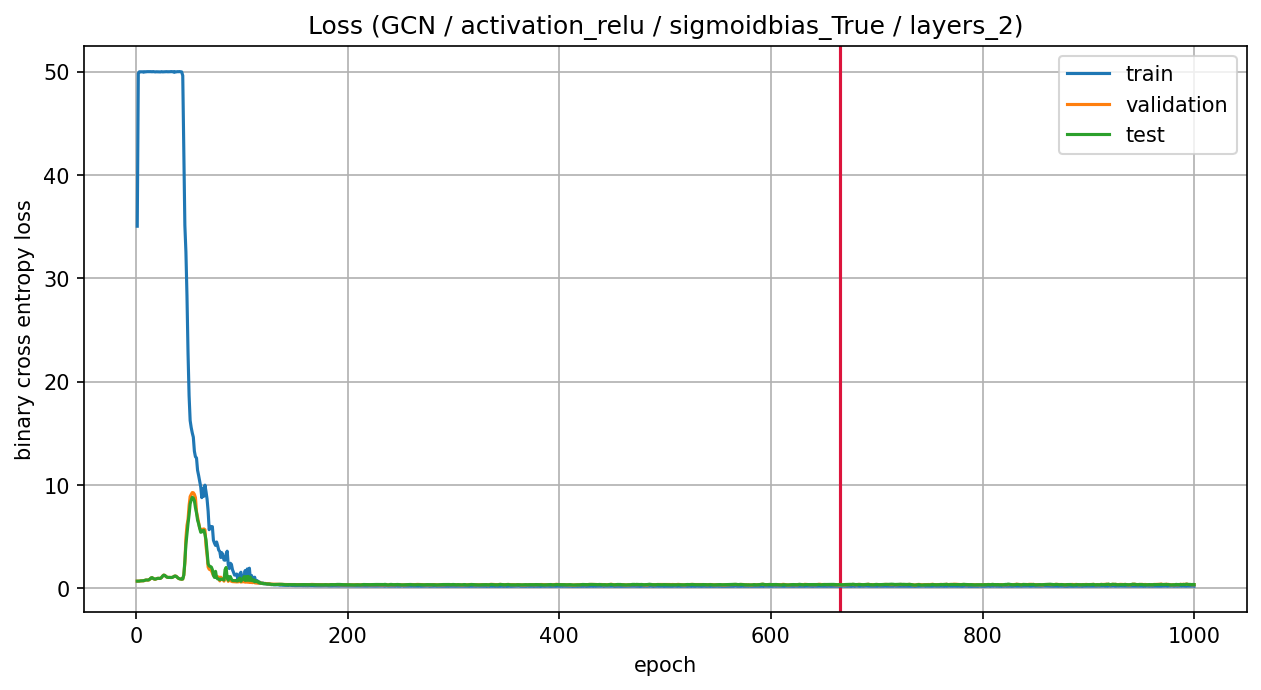

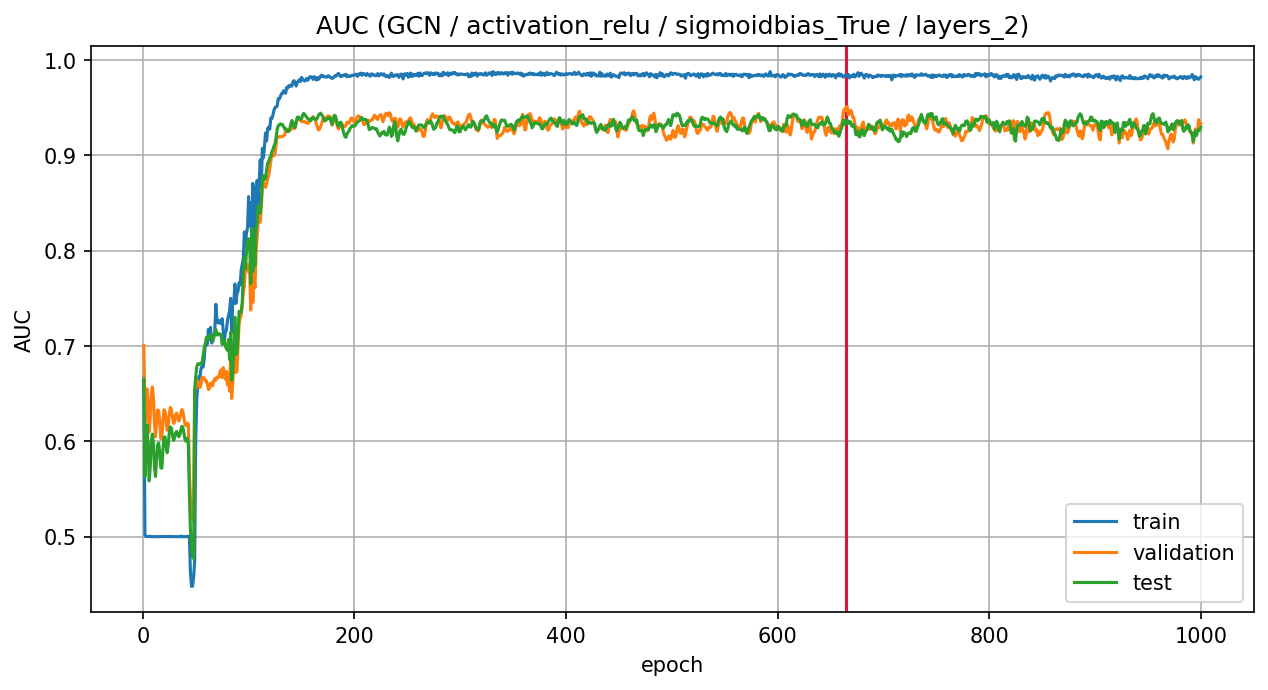

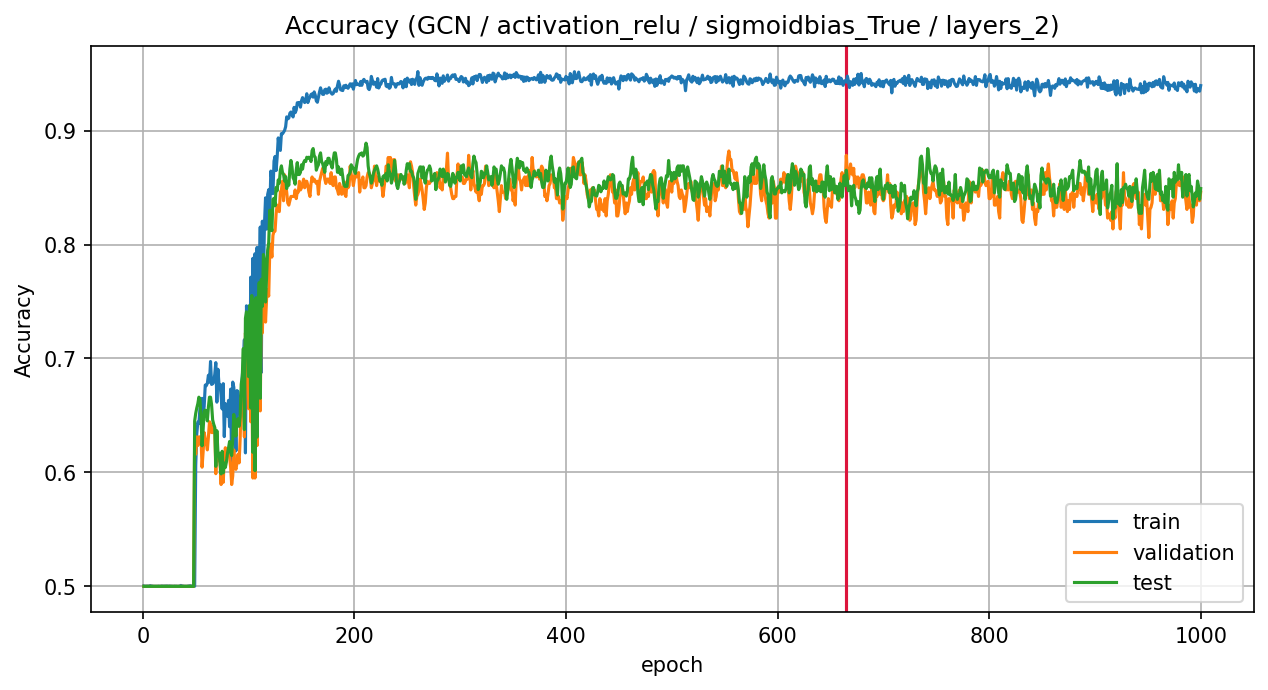

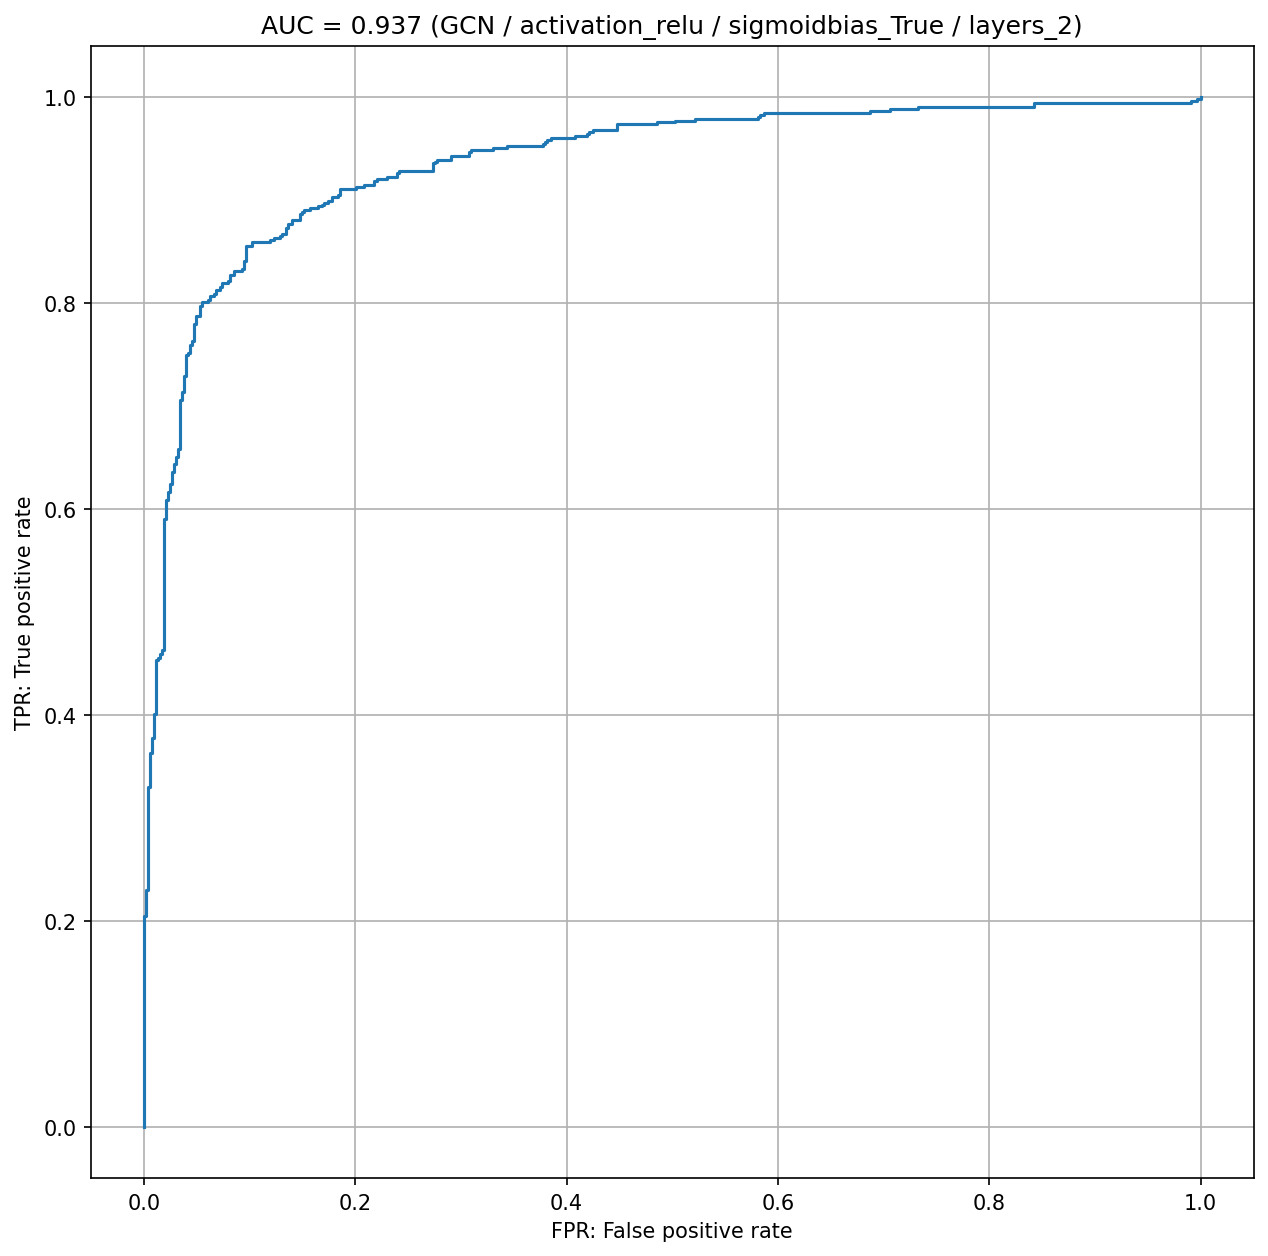

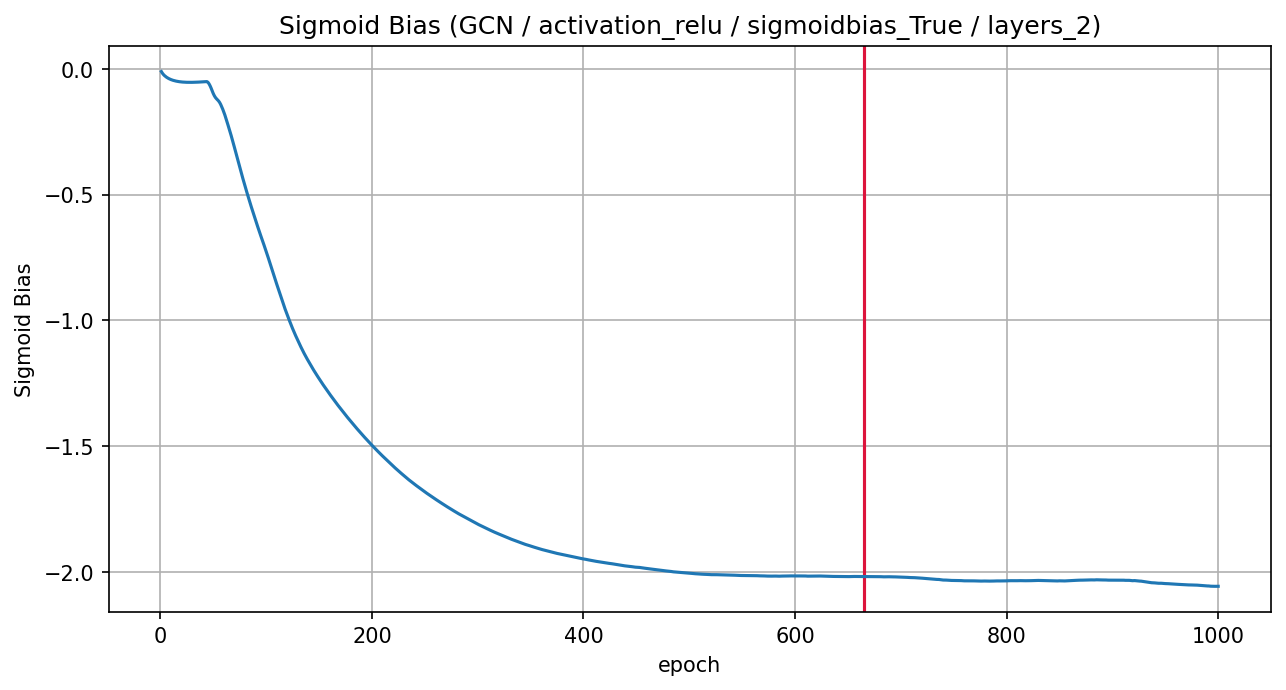

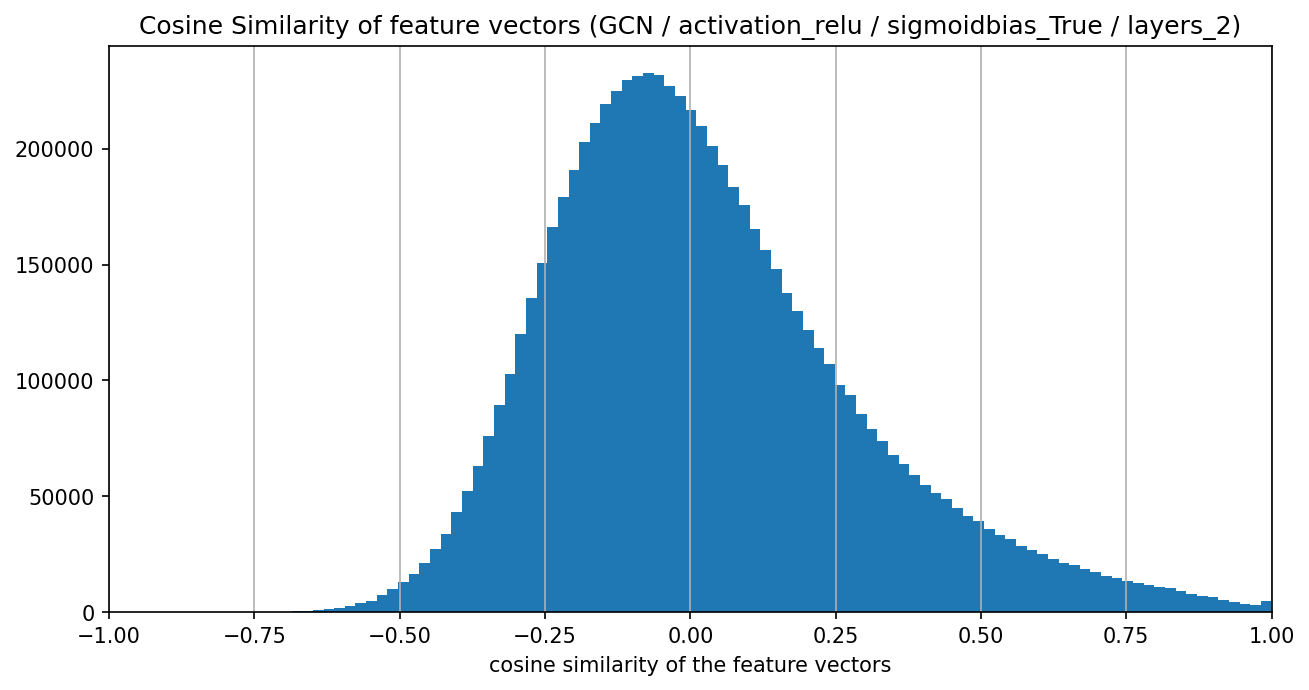

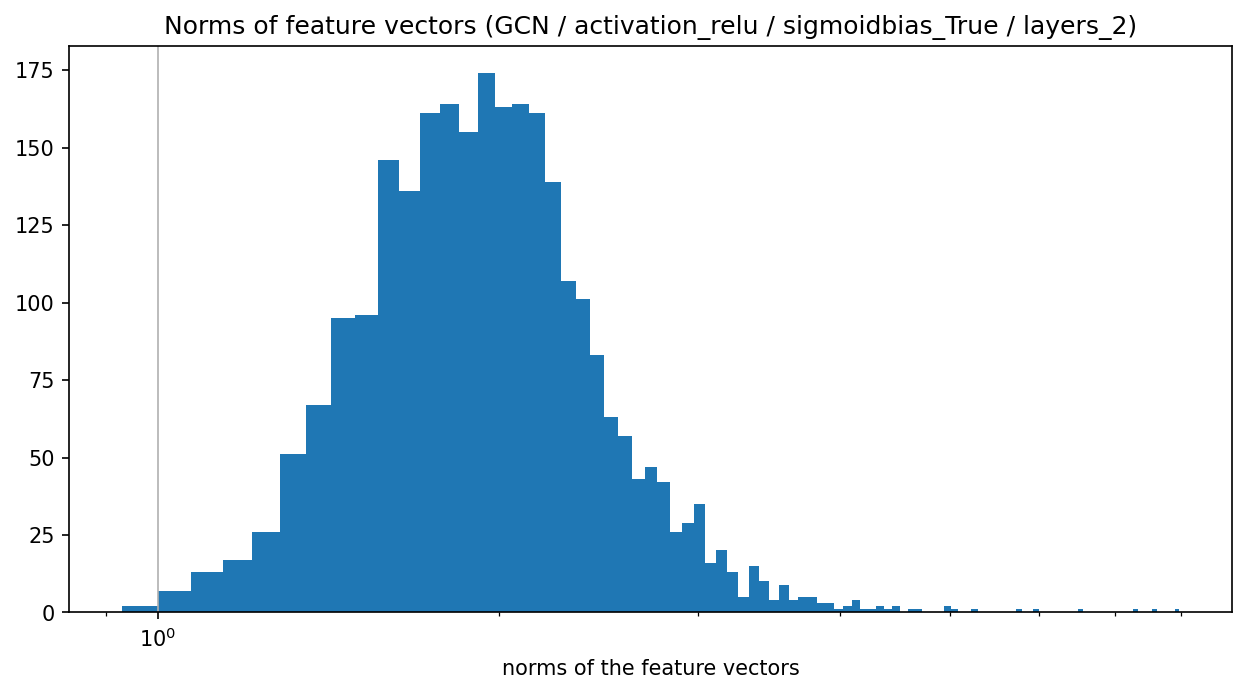

AUC: 0.9367332903657883
TP_410_FP_25_TN_502_FN_117
accuracy: 0.8652751423149905
precision: 0.9425287356321839
recall: 0.777988614800759


In [7]:
model.model_evaluate(validation=True, save=True)

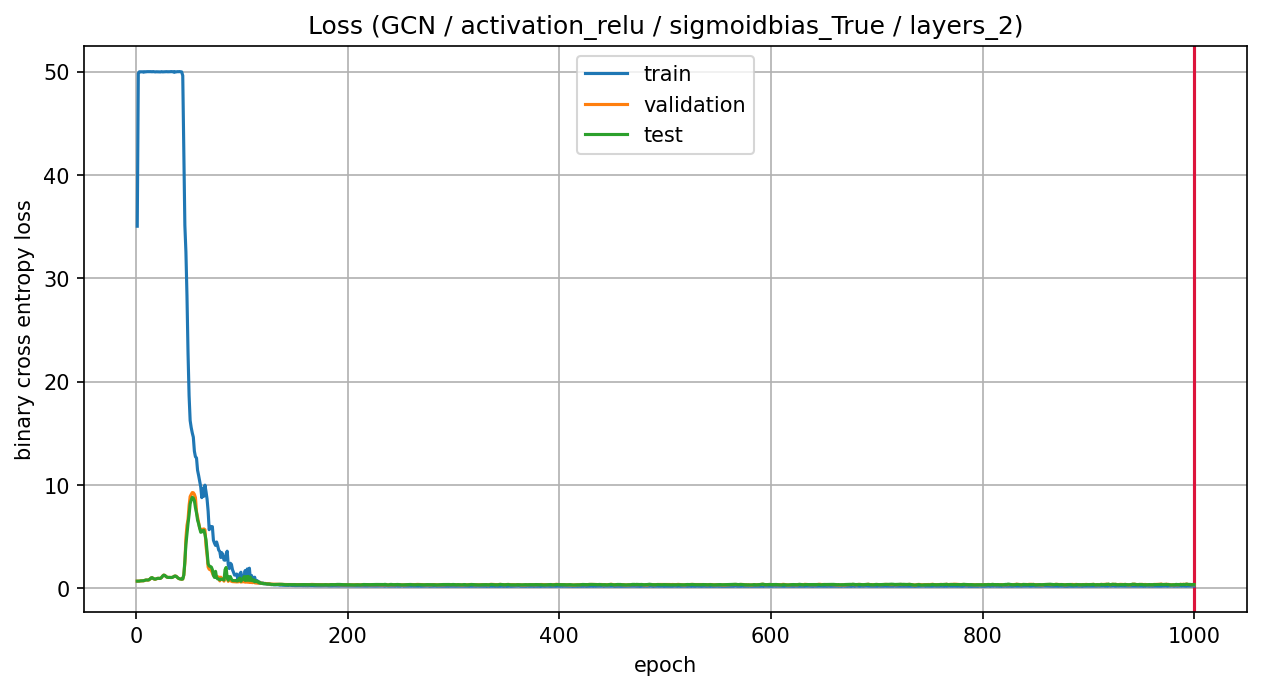

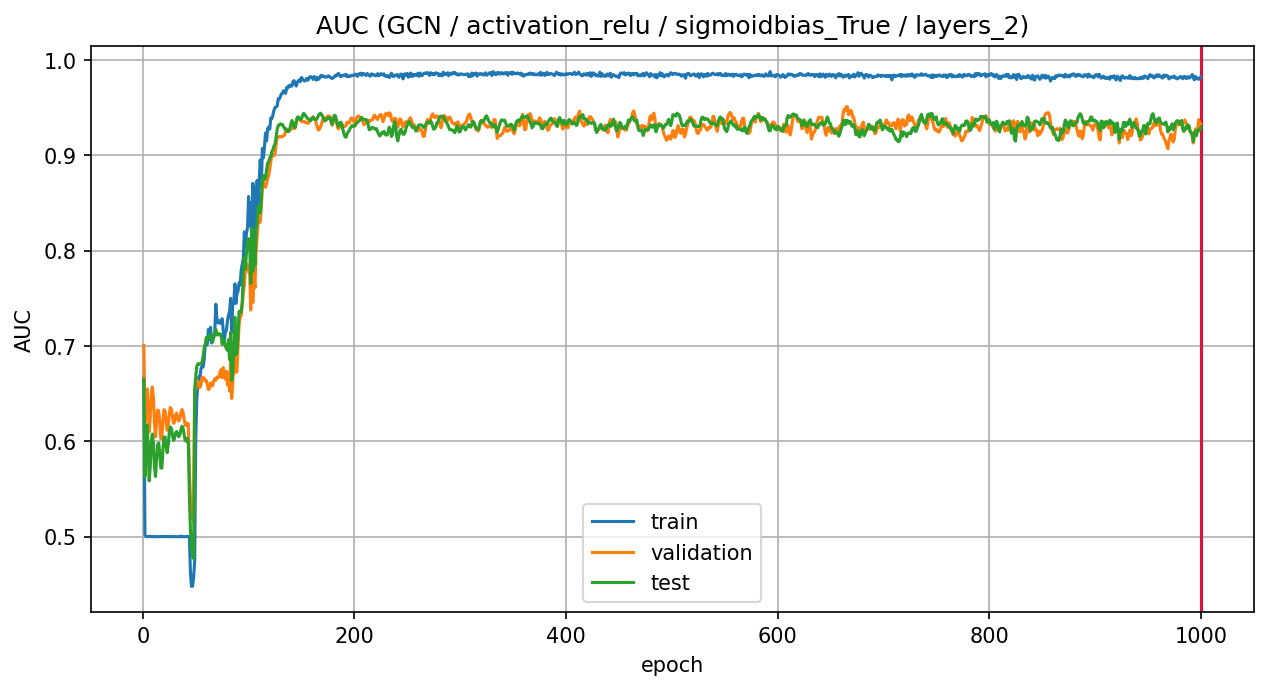

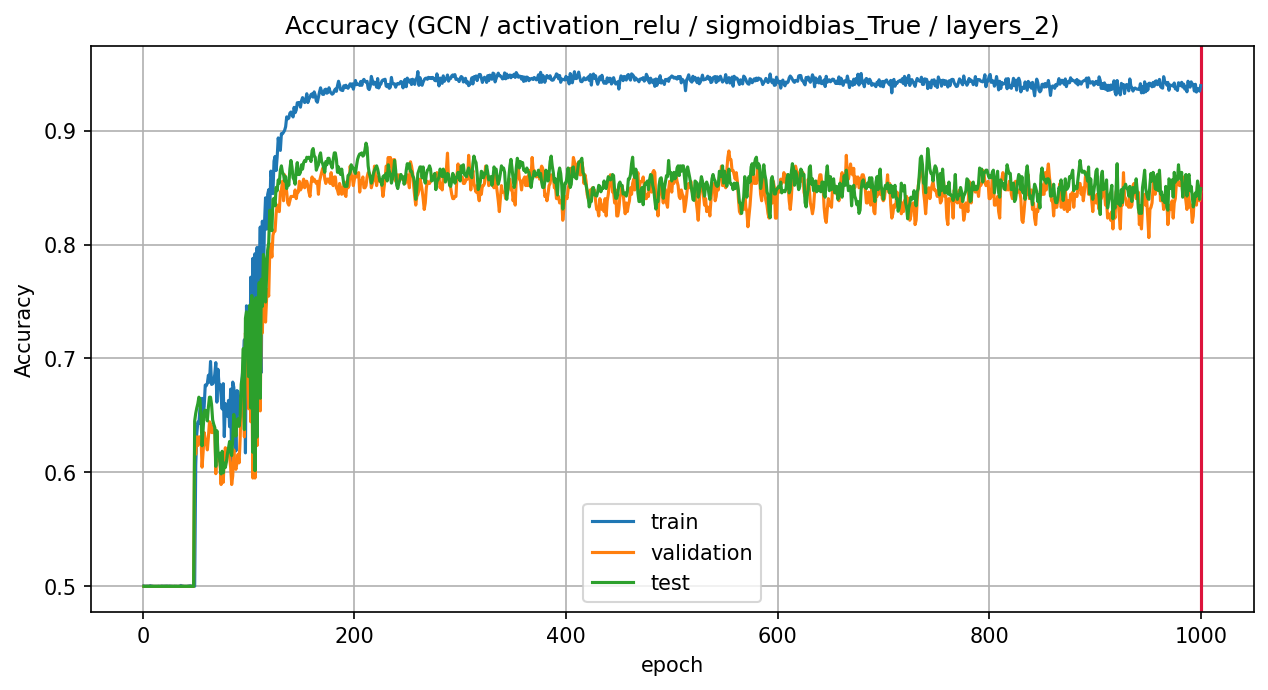

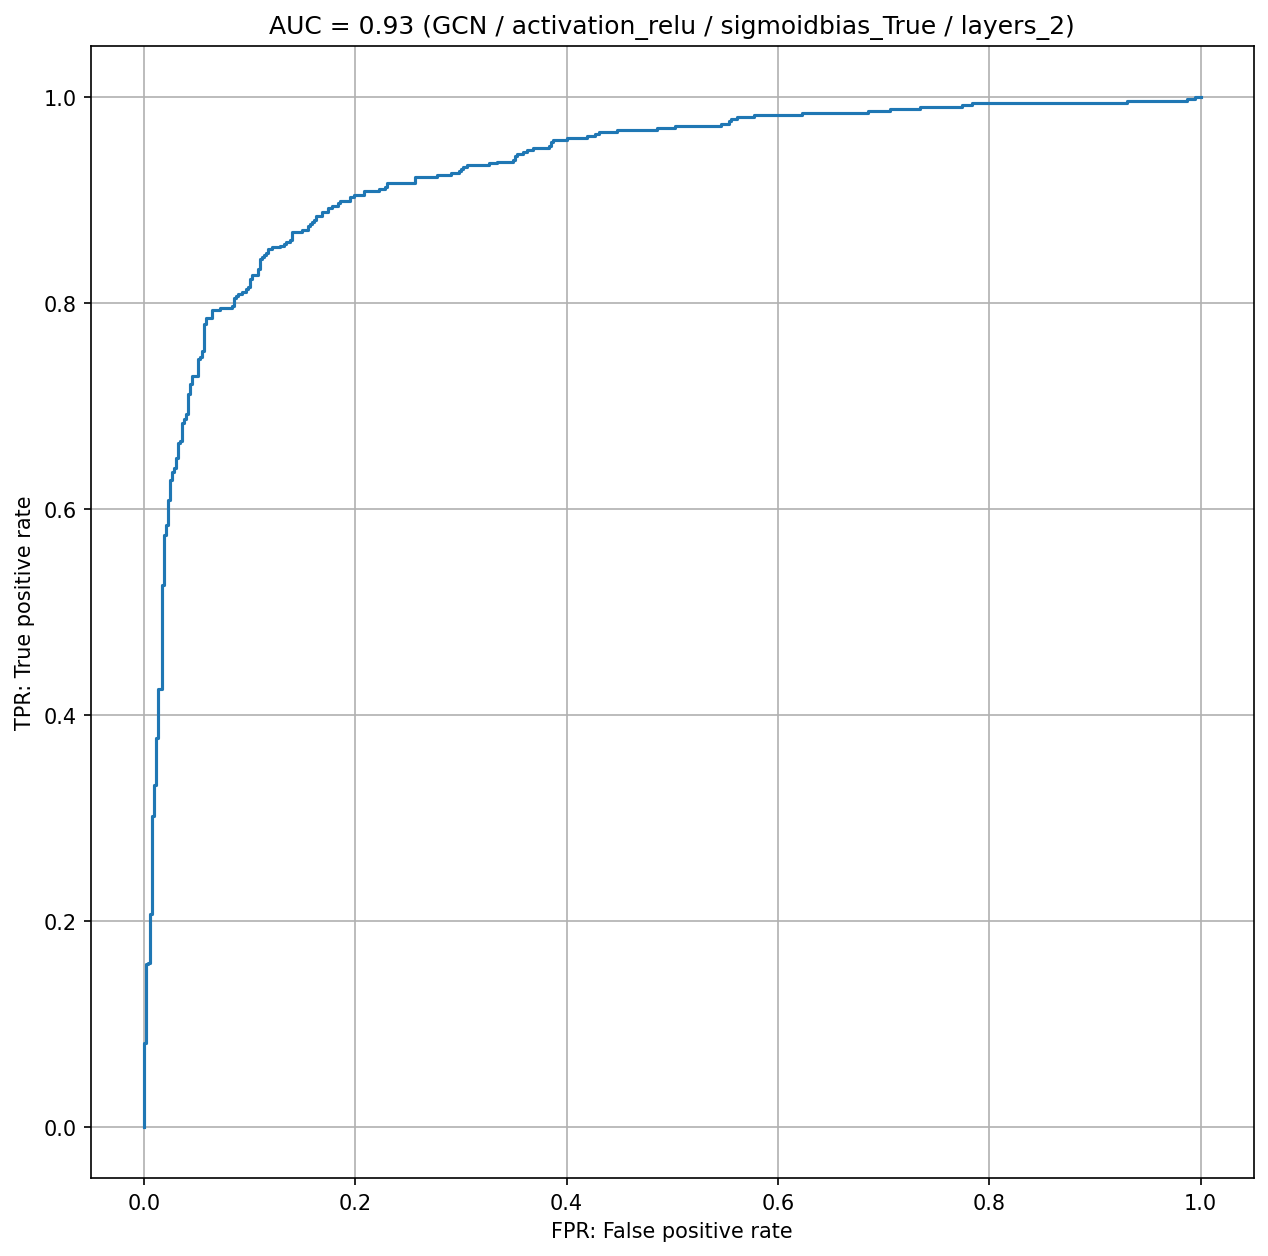

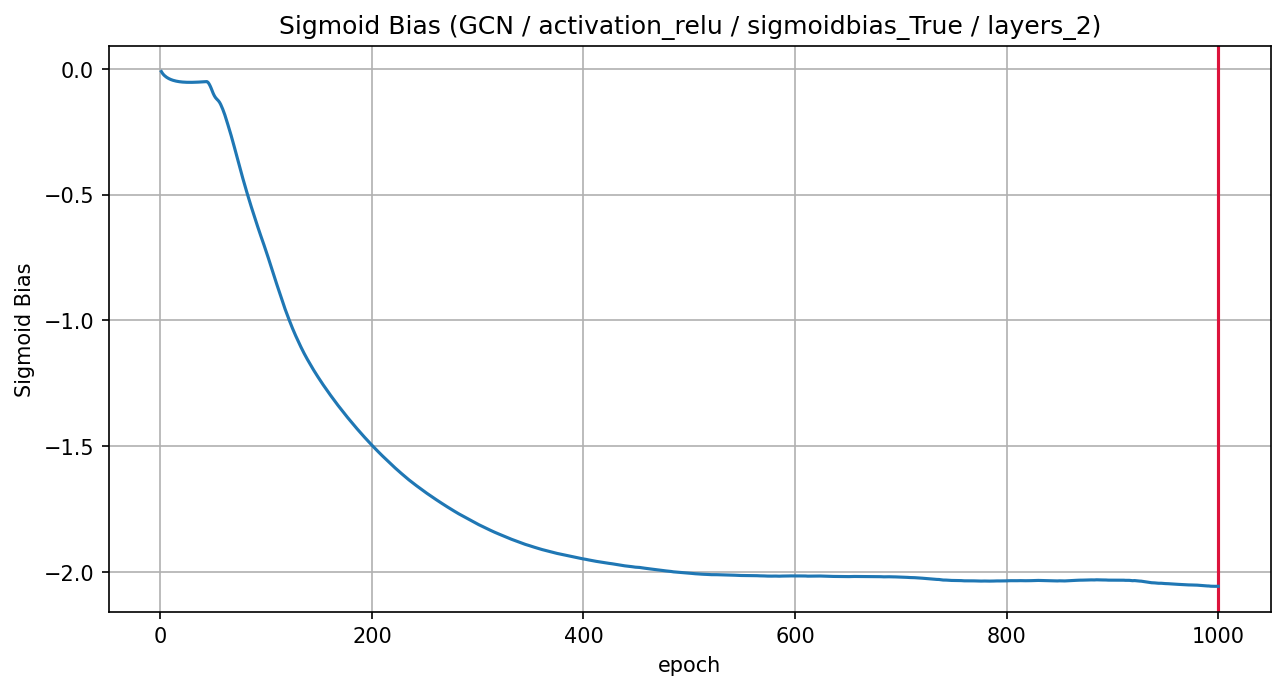

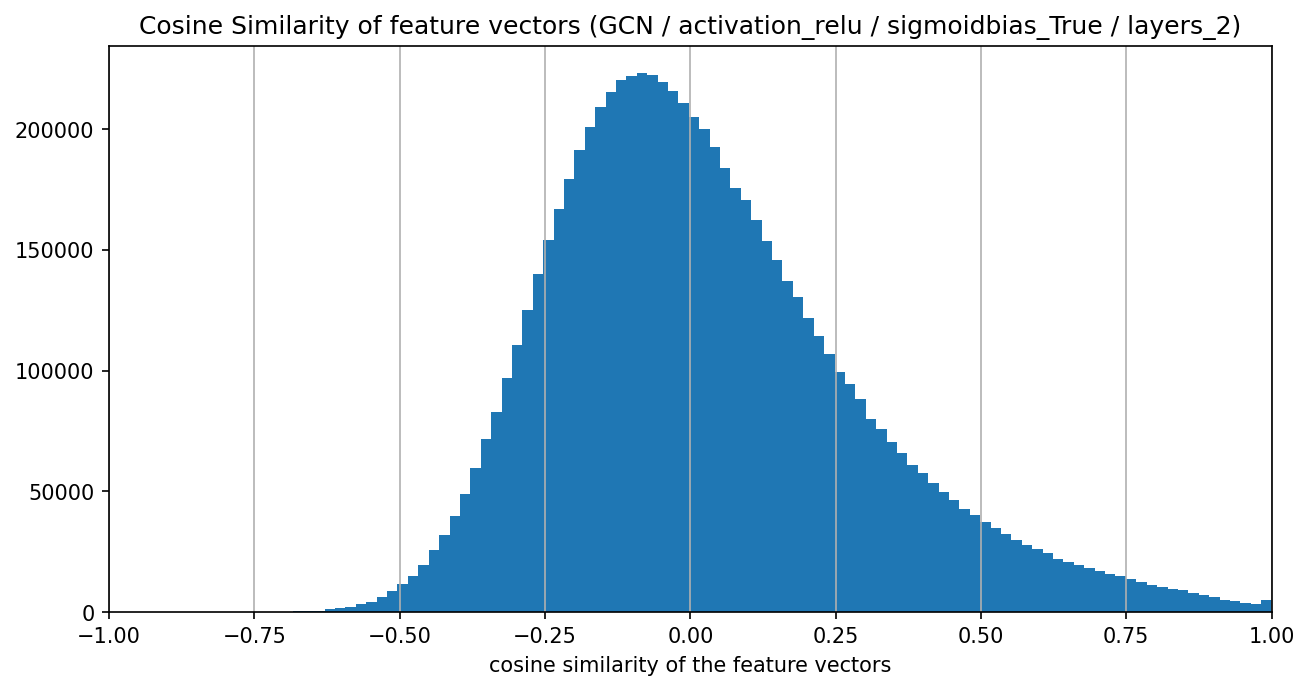

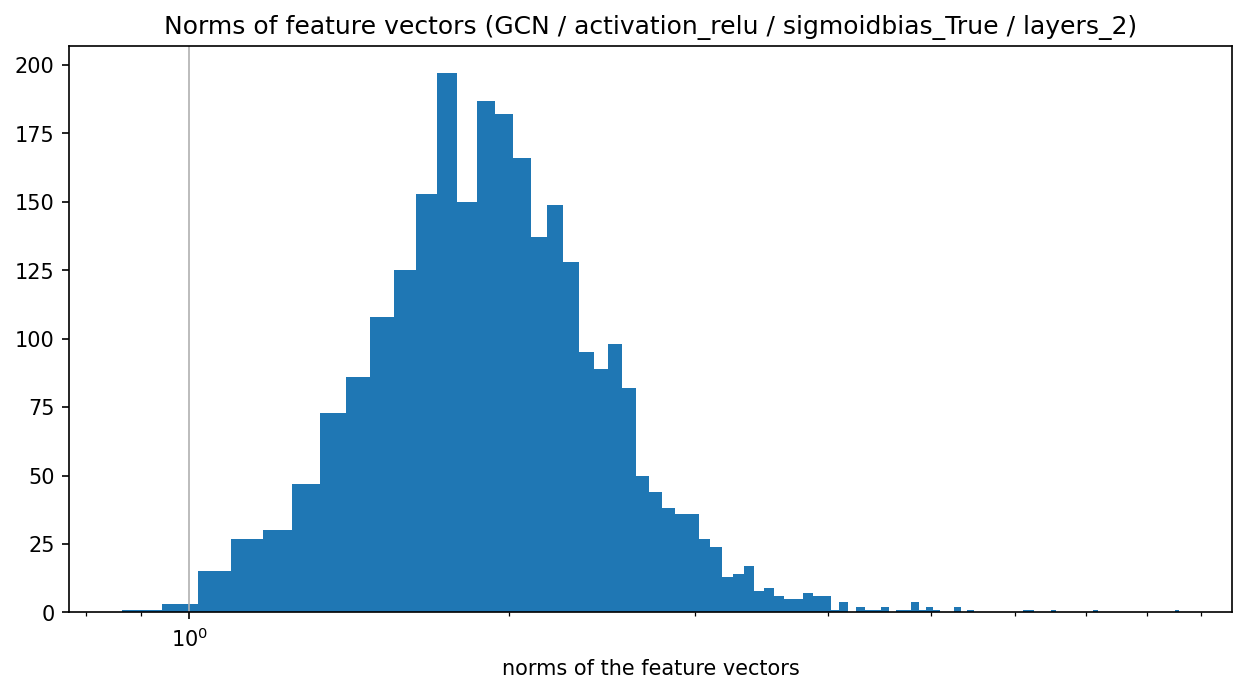

AUC: 0.929578834043258
TP_397_FP_29_TN_498_FN_130
accuracy: 0.849146110056926
precision: 0.931924882629108
recall: 0.7533206831119544


In [8]:
model.model_evaluate(validation=False, save=True)